# Практические задания по БД PostgreSQL

Импорт необходимых библиотек для работы.

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from sqlalchemy import create_engine 

# Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой мы будем работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
query_1 = '''
SELECT DATE_TRUNC ('month', creation_date) :: date AS month_date,
       SUM (views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT (YEAR FROM creation_date) IN ('2008')
GROUP BY DATE_TRUNC ('month', creation_date) :: date
ORDER BY total_views DESC
'''

pd.read_sql_query (query_1, con = engine)

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вывод**: Наименьшие показатели просмотров соответствуют первым двум месяцам после запуска сервиса (июль и август). Максимальное количество просмотров пришлось на сентябрь, после чего до конца года количество просмотров постепенно сокращалось. Это может быть связано с рекламной акцией, запущенной в сентябре для привлечения новых пользователей.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [5]:
query_2 = '''
WITH q1 AS (SELECT DISTINCT p.id AS post_id,
                   u.id AS user_id,
                   u.display_name,
                   u.creation_date AS user_date,
                   p.creation_date AS post_date,
                   COUNT (p.id) OVER (PARTITION BY u.display_name) AS answer_count
            FROM stackoverflow.posts AS p
            JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
            JOIN stackoverflow.users AS u ON p.user_id = u.id
            WHERE pt.type IN ('Answer')
            AND p.creation_date BETWEEN (u.creation_date) AND (u.creation_date + INTERVAL '1 month'))
SELECT display_name,
       COUNT (distinct user_id) AS id_count
FROM q1
WHERE answer_count > 100
GROUP BY display_name
ORDER BY id_count DESC
'''

pd.read_sql_query (query_2, con = engine).head(30)

,display_name,id_count
0,Chris,29
1,Matt,29
2,Dan,21
3,Tom,19
4,Mark,16
5,Josh,16
6,Nick,16
7,Rob,15
8,Brian,15
9,Greg,12


# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [6]:
query_3 = '''
WITH q1 AS (SELECT DISTINCT u.id AS user_id
            FROM stackoverflow.users AS u
            JOIN stackoverflow.posts AS p ON p.user_id = u.id
            WHERE DATE_TRUNC ('month', u.creation_date) IN ('2008-09-01')
            AND DATE_TRUNC ('month', p.creation_date) IN ('2008-12-01'))

SELECT DATE_TRUNC ('month', p.creation_date),
       COUNT (p.id)
FROM stackoverflow.posts AS p
JOIN q1 ON p.user_id = q1.user_id
GROUP BY DATE_TRUNC ('month', p.creation_date)
ORDER BY DATE_TRUNC ('month', p.creation_date) DESC
'''

pd.read_sql_query (query_3, con = engine)

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Вывод**: В результатах есть данные о постах за август, в то время как выборка состояла из пользователей, которые зарегистрировались в сентябре. Вероятно, ошибка в записи данных.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [7]:
query_4 = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM (views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id
'''

pd.read_sql_query (query_4, con = engine)

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [8]:
query_5 = '''
WITH q1 AS (SELECT user_id,
                   COUNT (id) AS posts_count
            FROM stackoverflow.posts
            WHERE DATE_TRUNC ('month', creation_date) :: date IN ('2008-08-01')
            GROUP BY user_id
            HAVING COUNT (id) > 120),
            
q2 AS (SELECT DISTINCT p.user_id,
              q1.posts_count,
              DATE_TRUNC ('day', creation_date) :: date AS days_of_august
       FROM stackoverflow.posts AS p
       JOIN q1 ON q1.user_id = p.user_id
       WHERE DATE_TRUNC ('month', creation_date) :: date IN ('2008-08-01')
       ORDER BY p.user_id)
      
SELECT DISTINCT user_id,
       posts_count / (COUNT (days_of_august) OVER (PARTITION BY user_id) * 1.0) AS avg_daily
FROM q2
ORDER BY avg_daily
'''

pd.read_sql_query (query_5, con = engine).head (50)

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [9]:
query_6 = '''
WITH q1 AS (SELECT DISTINCT user_id,
                   DATE_TRUNC ('day', creation_date) :: date AS days_range
            FROM stackoverflow.posts
            WHERE DATE_TRUNC ('day', creation_date) :: date BETWEEN ('2008-12-01') AND ('2008-12-07')
            GROUP BY user_id, DATE_TRUNC ('day', creation_date) :: date),
            
     q2 AS (SELECT user_id,
                   COUNT (days_range) AS days_count
            FROM q1
            GROUP BY user_id)
            
SELECT ROUND (AVG (days_count))
FROM q2
'''

pd.read_sql_query (query_6, con = engine)

,round
0,2.0


**Вывод**: Из 7-и дней начала декабря, в среднем пользователеи оставляли посты всего 2 дня. Это низкий показатель, который, скорее всего, говорит о технических ошибках на сервере в этот период

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [10]:
query_7 = '''
WITH q1 AS (SELECT user_id,
                   creation_date,
                   LAG (EXTRACT (MONTH FROM creation_date), 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month_n
            FROM stackoverflow.posts
            ORDER BY (user_id, creation_date))
SELECT user_id,
       creation_date,
       CASE
           WHEN second_last_month_n = 1 THEN 'Январь'
           WHEN second_last_month_n = 2 THEN 'Февраль'
           WHEN second_last_month_n = 3 THEN 'Март'
           WHEN second_last_month_n = 4 THEN 'Апрель'
           WHEN second_last_month_n = 5 THEN 'Май'
           WHEN second_last_month_n = 6 THEN 'Июнь'
           WHEN second_last_month_n = 7 THEN 'Июль'
           WHEN second_last_month_n = 8 THEN 'Август'
           WHEN second_last_month_n = 9 THEN 'Сентябрь'
           WHEN second_last_month_n = 10 THEN 'Октярь'
           WHEN second_last_month_n = 11 THEN 'Ноябрь'
           WHEN second_last_month_n = 12 THEN 'Декабрь'
        END AS second_last_month
FROM q1
'''

pd.read_sql_query (query_7, con = engine).head(10)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,Июль
3,1,2008-08-04 02:45:08,Июль
4,1,2008-08-04 04:31:03,Июль
5,1,2008-08-04 08:04:42,Август
6,1,2008-08-10 08:28:52,Август
7,1,2008-08-11 19:23:47,Август
8,1,2008-08-12 00:30:43,Август
9,1,2008-08-12 04:59:35,Август


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [11]:
query_8 = '''
WITH q1 AS (SELECT DISTINCT user_id,
                   FIRST_VALUE (DATE_TRUNC ('month', creation_date) :: date) OVER (PARTITION BY user_id ORDER BY creation_date :: date) AS first_post_date
                  FROM stackoverflow.posts),
                  
     profiles AS (SELECT *,
                   COUNT (*) OVER (PARTITION BY first_post_date) AS cohort_size
            FROM q1),
            
     sessions AS (SELECT user_id,
                         DATE_TRUNC ('month', creation_date) :: date AS posts_date
                  FROM stackoverflow.posts
                  GROUP BY 1, 2)
SELECT first_post_date,
       posts_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_size,
       ROUND (COUNT (p.user_id) * 100.0 / cohort_size, 2) AS retention_rate
FROM sessions AS s
JOIN profiles AS p ON s.user_id = p.user_id
GROUP BY 1, 2, 4
ORDER BY 1, 2
'''

retention = pd.read_sql_query (query_8, con = engine)
retention

,first_post_date,posts_date,users_cnt,cohort_size,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Построим тепловую карту Retention Rate

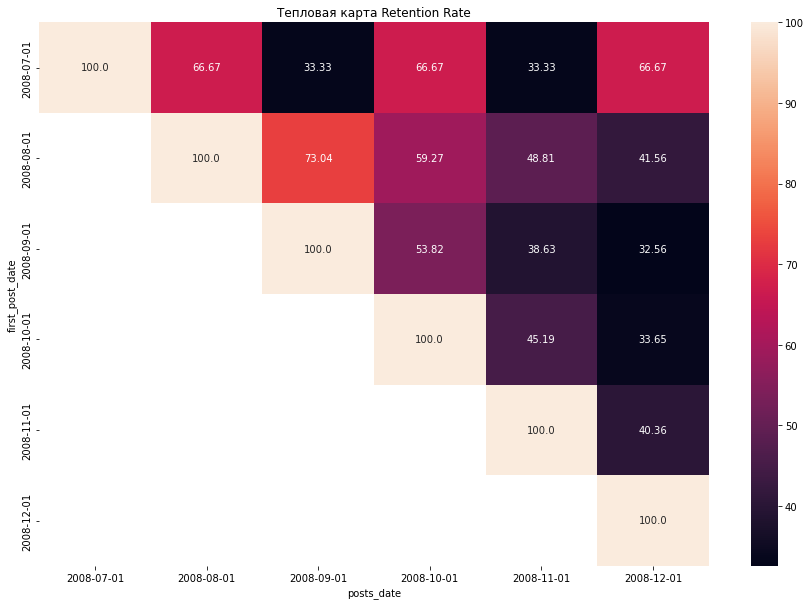

In [12]:
retention_pivot = retention.pivot ('first_post_date', 'posts_date', 'retention_rate')
plt.figure (figsize = (15, 10))
sns.heatmap (retention_pivot,
             annot = True,
             fmt = '')
plt.title ('Тепловая карта Retention Rate')
plt.show ()

**Вывод**: Июльская когорта имеет неравномерный показатель удержания по месяцам. Это связано с очень малой выборкой, т.к. это первый месяц использования сервиса. Даже незначительные изменения в количестве опубликованных постов сильно влияют на общую картину.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [13]:
query_9 = '''
WITH q1 AS (SELECT EXTRACT (MONTH FROM creation_date) AS creation_month,
                   COUNT (id) AS posts_count
            FROM stackoverflow.posts
            WHERE DATE_TRUNC ('month', creation_date) :: date BETWEEN ('2008-09-01') AND ('2008-12-31')
            GROUP BY creation_month),
     q2 AS (SELECT *,
                   LAG (posts_count) OVER () AS previous_count
            FROM q1)
SELECT *,
       CASE
           WHEN previous_count > posts_count THEN ROUND (((previous_count :: numeric - posts_count :: numeric) / previous_count :: numeric) * -100, 2)
           ELSE ROUND (((previous_count :: numeric - posts_count :: numeric) / previous_count :: numeric) * 100, 2)
       END AS percentage
FROM q2
'''

posts_percentage = pd.read_sql_query (query_9, con = engine)
posts_percentage

,creation_month,posts_count,previous_count,percentage
0,9.0,70371,NaN,NaN
1,10.0,63102,70371.0,-10.33
2,11.0,46975,63102.0,-25.56
3,12.0,44592,46975.0,-5.07


Построим круговую диаграмму с количеством постов по месяцам.

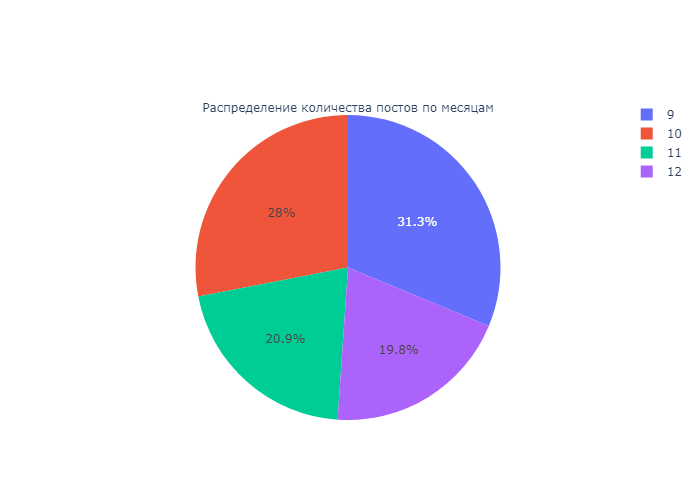

In [14]:
fig = go.Figure (data = [go.Pie (labels = posts_percentage ['creation_month'],
                                 values = posts_percentage ['posts_count'],
                                 title = 'Распределение количества постов по месяцам')])
fig.show ('png')

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [15]:
query_10 = '''
WITH q1 AS (SELECT user_id,
                   COUNT (id) AS posts_count
            FROM stackoverflow.posts
            GROUP BY user_id
            ORDER BY posts_count DESC
            LIMIT 1)
SELECT EXTRACT (WEEK FROM creation_date) AS week_creation,
       MAX (creation_date) AS creation_date
FROM stackoverflow.posts AS p
JOIN q1 ON q1.user_id = p.user_id
WHERE DATE_TRUNC ('month', creation_date) :: date IN ('2008-10-01')
GROUP BY EXTRACT (WEEK FROM creation_date)
ORDER BY 1, 2
'''

pd.read_sql_query (query_10, con = engine)

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
